# Pulizia dati
Il seguente programma permette di individuare ed eliminare i momenti di pause tra una traccia e l'altra.
Restituisce come risultato gli indici delle tracce.


In [1]:
# impor the pandas library to read csv file and 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

In [35]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

file = "20200805_075428_MWALK_#0001.csv"
#file = "20200805_084714_MWALK_#0001.csv"

data = pd.read_csv("./input/{}".format(file), 
                      sep=';',      # define the column separator as ";" instead of ,
                      skiprows=21,  # skip the first 21 row
                      header=0,     # define the header where the column names are defined 
                      index_col=0   # set the timestamp as the row identifier
                 )
# delete the space in the column name. e.g. From " B1x[nT]" to "B1x[nT]"
data.columns = data.columns.str.replace(' ', '')

# print first 4 row in the dataset
print(data.head(2))

# print only the column  accx[g]
raw = data['AccX[g]']


                 B1x[nT]   B1y[nT]  B1z[nT]   B2x[nT]   B2y[nT]  B2z[nT]  \
Timestamp [ms]                                                             
0               26019.71 -35822.08 -8894.09  25921.18 -35598.18 -9799.92   
5               26034.58 -35836.68 -8863.05  25935.08 -35614.06 -9764.60   

                AccX[g]  AccY[g]  AccZ[g]  Temp[Deg]  \
Timestamp [ms]                                         
0                -0.925    0.105   -0.177       35.0   
5                -0.941    0.103   -0.171       35.0   

                Latitude[DecimalDegrees]  Longitude[DecimalDegrees]  \
Timestamp [ms]                                                        
0                                    0.0                        0.0   
5                                    0.0                        0.0   

                Altitude[m]  Satellites  Quality  GPSTime  Unnamed:17  
Timestamp [ms]                                                         
0                       0.0           0  

## Functions to search stops 
There are two functions:
 - *find_all_little_stops*: find the little stops by searching a stopWalk pattern followed by a starWalk pattern
 - *obtain_big_stop_from_little_stops*: return the indexes of the big stop (two consecutive little stops(

In [36]:
NUM_ZEROS_PATTERN = 400 #125
# tif the accelartion is between this two limit is considered 0 accelaration => no walk.
UPPER_LIMIT_NO_ACCEL = -0.93
LOWER_LIMIT_NO_ACCEL = -1.07

# Convert the array of accellation into an array of boolean, 
# where True indentify no walk (acc in the range of no accel), False means Yes walk.
def _from_acc_to_bool(dataAcc, lowerAccLimit=LOWER_LIMIT_NO_ACCEL, upperAccLimit=UPPER_LIMIT_NO_ACCEL):    
    # between this range, the accelaration is as no accelaration
    # Convert into an array that contains only True (is not walking) and False (is walking)
    # noWalking contains True if there is no acceleration (not walking) False otherwise
    noWalking = dataAcc.between(lowerAccLimit, upperAccLimit)
    
    if len(noWalking) != len(dataAcc):
        raise("ERROR; no equal length")
    
    # transform the array of boolean into an array of string 1 and 0, 
    noWalking = pd.Series(data=[0 if x == True else 1 for x in noWalking], index=noWalking.index)    
    return  noWalking

def find_all_little_stops(dataAcc, 
                        stopWalkPattern="1" + ''.join("0" for i in range(NUM_ZEROS_PATTERN)),
                        startWalkPattern=''.join("0" for i in range(NUM_ZEROS_PATTERN)) + "1"):
    
    
    dataAccWithZeroOne =  _from_acc_to_bool(dataAcc)
    # All the little stops are found by searching a specific pattern in the sequence of zero an ones.
    # A single stop is a seuqence of a stopWalk pattern followed by a startWalk pattern. 
    #     1 00000000: (stop walking pattern): a sequence of type  1 000...000     
    #     00000000 1: (start walking pattern): a sequence of type   000....0000 1 
    
    import re
    # Obtain a string of zeros and ones
    noWalkingString = dataAccWithZeroOne.astype(str).str.cat()
    
    # Create a list of indexes where occurs a stopWalk pattern
    stopWalkinIndexes = []
    for match in re.finditer(stopWalkPattern, noWalkingString):
        s = match.start() 
        e = match.end()
        start = s + 1  # add 1 beacause the pattern is 10000 but the stop init with the first 0
        # from the index of the string to the index in the dataframe
        idx = dataAcc.index[start]
        stopWalkinIndexes.append(idx)

    # Create a list of indexes where occurs a startWalk pattern
    startWalkIndexes = []
    for match in re.finditer(startWalkPattern, noWalkingString):
        s = match.start()
        e = match.end()
        end =  e -1
        idx = dataAcc.index[end]
        startWalkIndexes.append(idx)
        
    if len(startWalkIndexes) != len(stopWalkinIndexes):
            raise Exception("Impossible to find little stops. # stopwalk:{} and # startwalk:{}.".format(len(stopWalkinIndexes), len(startWalkIndexes)))

    # TODO: check that the two list are of the same length
    # Build the list of all the little stops found by zipping the stap and start indexes. 
    # E.g. zip([0,2][1,3]) = [(0,1)(2,3)]
    littleStops = list(zip(stopWalkinIndexes, startWalkIndexes))
  
    return littleStops

def obtain_big_stop_from_little_stops(lstops):
    # if there are an odd number of littleSteps, there is something wrong...
    if len(lstops) % 2 != 0:
        raise Exception("Impossibe to obtain big stop. There are an odd number of little stops")
        
    bigStops = [] # list of tuple. Each tuple contains the big stop indexes (start, stop).
   
    # obtain all the big stop, by joining the couple of little stops
    # E.g. from two little stops (0,1)(2,3) (4,5)(6,7) to  big stops (0,3), (4,7)
 
    for i in range(0, len(lstops), 2):
        if i < len(lstops):
            first = lstops[i]
            start = first[0]    # take the start of the first little stop
            if i + 1 < len(lstops):
                second = lstops[i+1]
                stop = second[1]   # take the end of the second little stop
            else:
                stop = first[0] 
            bigStops.append((start, stop))
    return bigStops


Number of big stops: 9


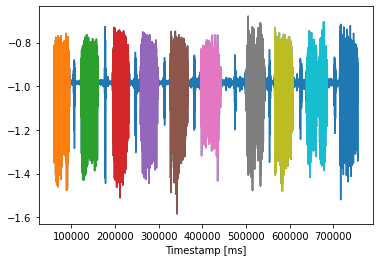

In [41]:
import matplotlib.pyplot as plt
plt.close('all')
 

acc = data['AccX[g]']

from_row = 12000
to_row = len(acc)-2000

acc = acc[from_row:to_row]
acc.plot()

littleStops = find_all_little_stops(acc)

#print all little stops
for ls in littleStops:
    t =acc.loc[ls[0]:ls[1]]
    #t.plot()

bigStops = obtain_big_stop_from_little_stops(littleStops)

print("Number of big stops:", len(bigStops))
#for bs in bigStops:
#    t =acc.loc[bs[0]:bs[1]]
#    t.plot()

walks = []
# save into output folder
for i, (init, end) in enumerate(bigStops):
    if i == 0:
        walks.append((from_row, init))
    else:
        prv = bigStops[i-1]
        walks.append((prv[1], init))

# plot big steps
for i, (init, end) in enumerate(walks):
    t = acc.loc[init:end]
    t.plot()
    
# save into csv
for i, (init, end) in enumerate(walks):
    t =data.loc[init:end]
    t.to_csv('./output/{}_{}.csv'.format(file, i))
